# Projection

$V(\mathbf{r}) \rightarrow \tilde{V}(\mathbf{k}) \rightarrow \{ \tilde{V}_{p}^{(R)}(\mathbf{k}_{p}) =  \tilde{V}(R(\mathbf{k}_{p},0)) \}_{R} \rightarrow \{ V_{p}^{(R)}(r_{p}) \}_{R} $

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import mdtraj
import ipyvolume as ipv
from scipy.stats import special_ortho_group

In [2]:
coords = mdtraj.load('./material/simple_data/3pqr.pdb').xyz[0,::100,...]*10
radius = 10*np.ones(coords.shape[0])

In [3]:
L  = 150
nx = 64

In [6]:
volume, crds = init_volume(nx, L, crds=coords, rad=radius)

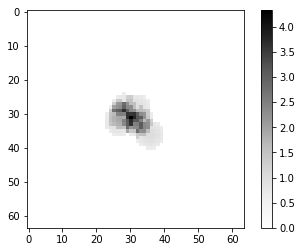

In [7]:
display_dimension = 2
if(display_dimension < 3):
    plt.imshow(volume[int(nx/2),...], cmap='Greys')
    plt.colorbar()
else:
    ipv.quickvolshow(volume, level=[0.1, 0.1], opacity=0.1)

In [8]:
volume_fourier = ft_volume(volume, shift=False)
volume_psd = np.log(np.abs((volume_fourier))**2)

In [9]:
ipv.quickvolshow(volume_psd, level=[0.7, 0.1], opacity=0.1)

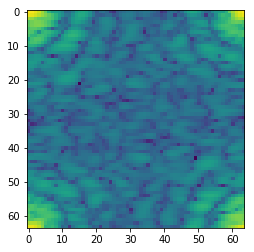

In [10]:
plt.imshow(volume_psd[:,:,0])

In [11]:
ft_slice   = slice_ft_volume(volume_fourier)
projection = ft_slice_to_projection(ft_slice)

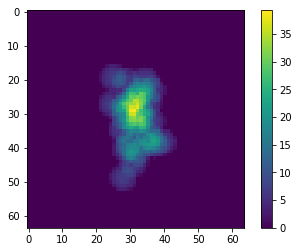

In [52]:
plt.imshow(np.real(projection))
plt.colorbar()

In [128]:
kp = np.zeros((ft_slice.shape[0]*ft_slice.shape[1],3))
k=0
for i in np.arange(ft_slice.shape[0]):
    for j in np.arange(ft_slice.shape[1]):
        kp[k,0] = i - int(nx/2)
        kp[k,1] = j - int(nx/2)
        kp[k,2] = 0
        k+=1

In [189]:
rotmat = special_ortho_group.rvs(3)
#rotmat = np.identity(3)
print(rotmat)

[[ 0.84277132 -0.51742023 -0.14836715]
 [-0.39067338 -0.39836763 -0.82986598]
 [ 0.37028477  0.75735034 -0.53787512]]


In [190]:
# This works!
#kp_shift = kp - np.where(kp>0,1,kp)*(int(nx/2))
#kp_shift

In [191]:
k_new = np.dot(kp,rotmat).astype('int')

In [192]:
print(kp)
print(k_new)

[[-32. -32.   0.]
 [-32. -31.   0.]
 [-32. -30.   0.]
 ..., 
 [ 31.  29.   0.]
 [ 31.  30.   0.]
 [ 31.  31.   0.]]
[[-14  29  31]
 [-14  28  30]
 [-15  28  29]
 ..., 
 [ 14 -27 -28]
 [ 14 -27 -29]
 [ 14 -28 -30]]


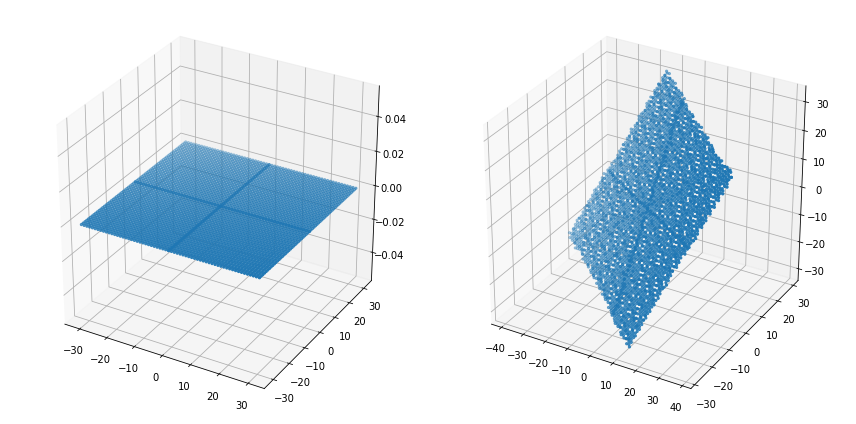

In [193]:
#plt.plot(kp[:,0], kp[:,1],'.')
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(kp_shift[:,0], kp_shift[:,1], kp_shift[:,2], marker='.')
ax = fig.add_subplot(122, projection='3d')
ax.scatter(k_new[:,0], k_new[:,1], k_new[:,2], marker='.')
plt.tight_layout()
plt.show()

In [194]:
print(k_new, k_new.shape, k_new[4095,0])

[[-14  29  31]
 [-14  28  30]
 [-15  28  29]
 ..., 
 [ 14 -27 -28]
 [ 14 -27 -29]
 [ 14 -28 -30]] (4096, 3) 14


In [195]:
indices = np.indices(volume_fourier.shape)

In [196]:
volume_fourier[61,62,15]

(-117.74216777764465-31.73683616474144j)

In [197]:
new_slice = np.empty((ft_slice.shape)).astype(complex)
print(new_slice.shape)
k=0
for i in np.arange(ft_slice.shape[0]):
    for j in np.arange(ft_slice.shape[1]):
        #print(k_new[k,0],k_new[k,1],k_new[k,2])
        new_slice[i,j] = volume_fourier[k_new[k,0],k_new[k,1],k_new[k,2]]
        k+=1

(64, 64)


In [198]:
new_projection = ft_slice_to_projection(new_slice)

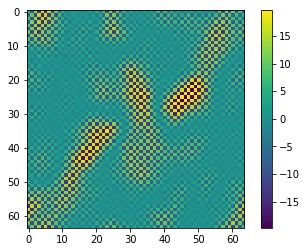

In [199]:
plt.imshow(np.real(new_projection))
plt.colorbar()

In [5]:
def ft_slice_to_projection(ft_slice):
    return np.fft.ifft2(ft_slice)

def slice_ft_volume(ft_volume):
    """
    """
    ft_slice = ft_volume[:,:,0]
    return ft_slice

def rotate_ft_volume(ft_volume, rotmat=None):
    """
    """
    rotated_volume = ndgriddata.griddata((grid_lon.flatten(), grid_lat.flatten()), 
                                          ft_volume.flatten(), 
                                          (X, Y), method="linear")

def init_volume(n, L, crds=None, rad=None):
    # initialize grid
    volume = np.zeros((n,n,n))
    if crds is not None:
        # recenter
        crds = crds - np.mean(crds, axis=0)
        volume = grid_density(volume, L, crds=crds, rad=rad)
    return volume, crds

def ft_volume(volume, shift=False):
    fourier_transform = np.fft.fftn(volume)
    if shift:
        n = volume.shape[0]
        ft_slice  = np.fft.fftshift(fourier_transform[int(n/2),:,:])
        ft_vol    = np.expand_dims(ft_slice, axis=0)
        for i in np.arange(1,n):
            if(i<n/2):
                j=i+n/2
            else:
                j=i-n/2
            ft_slice  = np.fft.fftshift(fourier_transform[int(j),:,:])
            ft_vol    = np.append(ft_vol,[ft_slice[:,:]],axis=0)
    else:
        ft_vol = fourier_transform
    return np.array(ft_vol)
            
def grid_density(volume, L, crds=None, rad=None):
    if crds is not None:
        for i in np.arange(volume.shape[0]):
            posx = -L/2 + i*L/(volume.shape[0]-1)
            for j in np.arange(volume.shape[1]):
                posy = -L/2 + j*L/(volume.shape[1]-1)
                for k in np.arange(volume.shape[2]):
                    posz = -L/2 + k*L/(volume.shape[2]-1)
                    for iat in np.arange(crds.shape[0]):
                        dx = crds[iat,0] - posx
                        dy = crds[iat,1] - posy
                        dz = crds[iat,2] - posz
                        dist2 = dx*dx + dy*dy + dz*dz
                        if(dist2 <= 100):
                            rad2  = rad[iat]**2
                            density = np.exp(-0.5*dist2/rad2)
                            volume[i,j,k] += density
                            #print(i,j,k,posx, posy, posz,volume[i,j,k])
    return volume

def display_volume(volume, d=2):
    #display_dimension = 2
    if(d < 3):
        plt.imshow(volume[int(nx/2),...], cmap='Greys')
        plt.colorbar()
    else:
        ipv.quickvolshow(volume, level=[0.1, 0.1], opacity=0.1)
                